# Imports and plot properties


In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mlt
import pandas as pd
from pandas import read_excel
from matplotlib.font_manager import FontProperties
from scipy.ndimage.interpolation import shift
import os
import glob
import timeit
from scipy import stats
import statsmodels.stats.api as sms
from matplotlib.collections import LineCollection
from tempfile import TemporaryFile
import matplotlib.gridspec as gridspec
import seaborn as sns
from statannot import add_stat_annotation
from scipy import signal
from pathlib import Path
from scipy.signal import butter, lfilter
from numpy.fft import rfft, fftfreq, fft,irfft, ifft
from scipy.ndimage import gaussian_filter1d
try:
    from statannot import add_stat_annotation
except ModuleNotFoundError:
    !conda install statannot
    
    
#from Locomotion import *
# import numpy_indexed as npi
#print(os.path.dirname(__file__))


#############################   Plot properties   ########################################################


font = FontProperties()
font.set_family('serif')
font.set_name('Times New Roman')
font.set_style('italic')
font.set_size('30')
font.set_weight('bold')

font_label = FontProperties()
font_label.set_family('serif')
font_label.set_name('Times New Roman')
font_label.set_style('italic')
font_label.set_size('25')
font_label.set_weight('bold')

def moving_average_array(X, n):
	'''Return the moving average over X with window n without changing dimesions of X'''

	z2= np.cumsum(np.pad(X, (n,0), 'constant', constant_values=0))
	z1 = np.cumsum(np.pad(X, (0,n), 'constant', constant_values=X[-1]))
	return (z1-z2)[(n-1):-1]/n
from scipy.signal import butter, lfilter

def butter_bandpass(lowcut, highcut, fs, order=5):
    nyq = 0.5 * fs
    low = lowcut / nyq
    high = highcut / nyq
    b, a = butter(order, [low, high], btype='band')
    return b, a


def butter_bandpass_filter(data, lowcut, highcut, fs, order=5):
    b, a = butter_bandpass(lowcut, highcut, fs, order=order)
    y = lfilter(b, a, data)
    return y



ModuleNotFoundError: No module named 'matplotlib.pyplot'

# Read DLC data

In [17]:
path = '/home/shiva/Desktop/Dyskinesia'
file_name = '#182_L-DOPA_opto_day15_0.5mWDLC_resnet50_Dyskinesia_Ldopa_MouseFeb5shuffle1_250000.csv'
df = pd.read_csv(os.path.join(path,file_name), header=[1,2])
print(df.head())

  bodyparts     implant                           wire_tip              \
     coords           x           y likelihood           x           y   
0         0  155.286758  168.643570        1.0  167.077393  122.687012   
1         1  155.864822  171.573227        1.0  165.743774  125.410904   
2         2  154.888916  168.829193        1.0  163.467941  120.272224   
3         3  152.804855  161.292587        1.0  155.300735  116.466949   
4         4  150.340134  159.616302        1.0  148.479691  117.907158   

                   ear_l                              ear_r              \
  likelihood           x           y likelihood           x           y   
0        1.0  163.978241  141.658554   1.000000  124.453072  155.232269   
1        1.0  162.532288  146.672440   1.000000  125.588402  160.618103   
2        1.0  160.729446  142.639954   1.000000  122.895538  156.570084   
3        1.0  176.515823  199.870377   0.997294  118.683212  158.436096   
4        1.0  171.551315  199.3

# Filter time series

1000 (1000,) (1000,)
tremor freq = 4.75


Text(0, 0.5, 'amplitude')

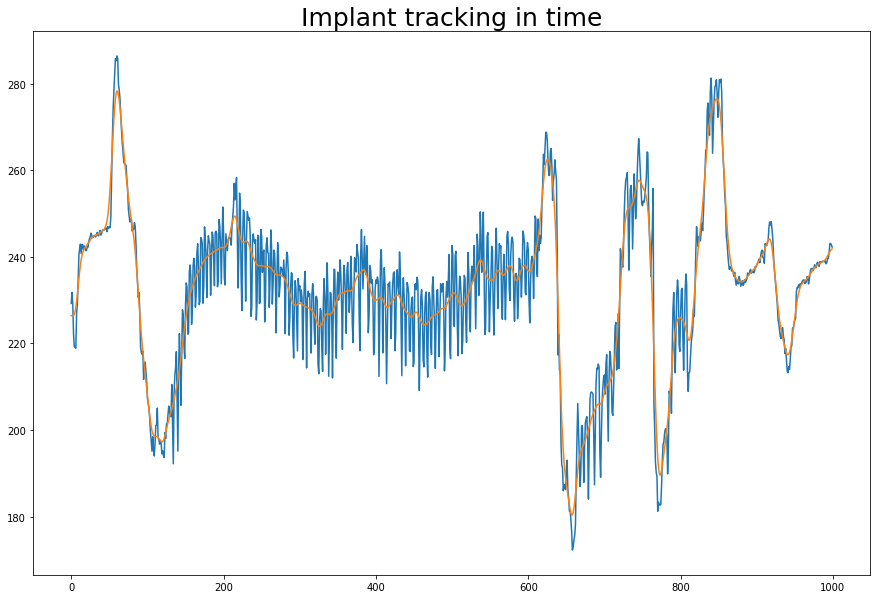

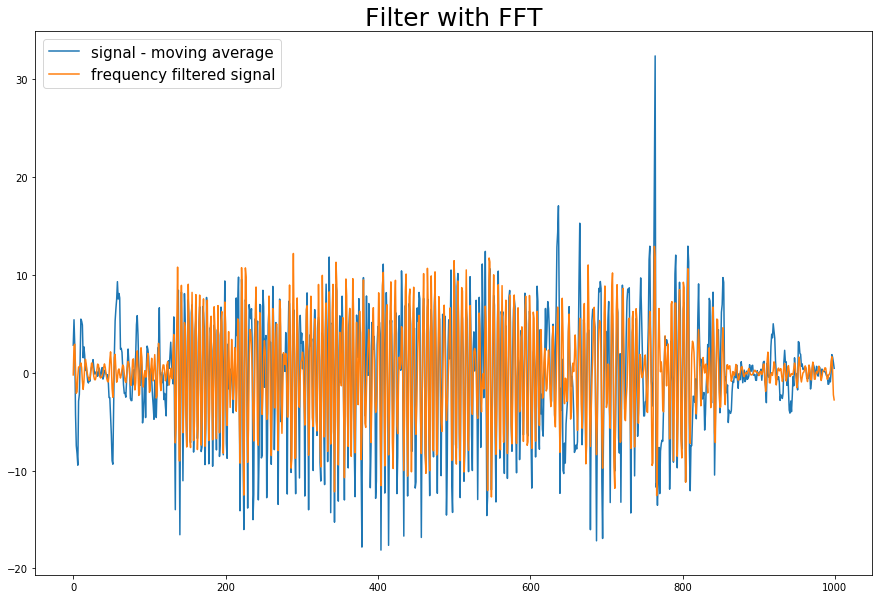

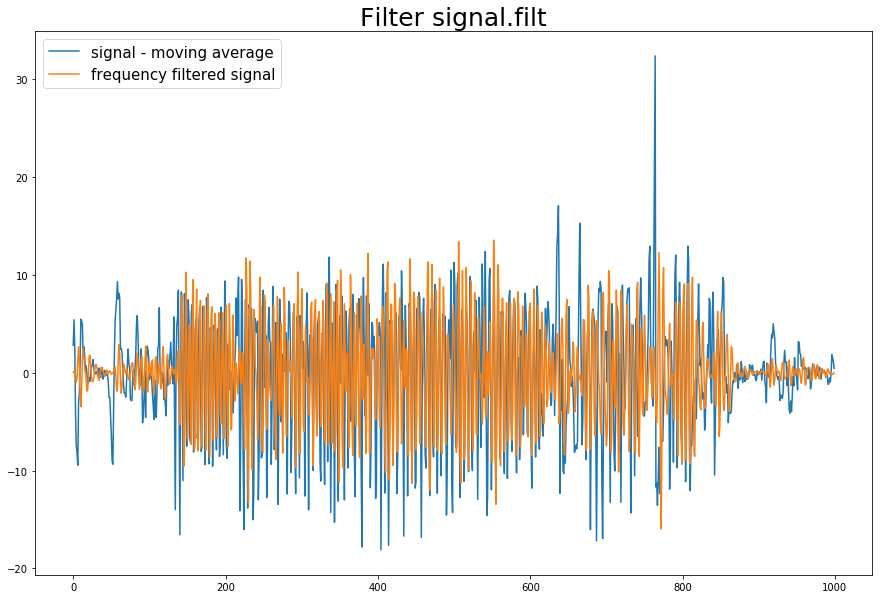

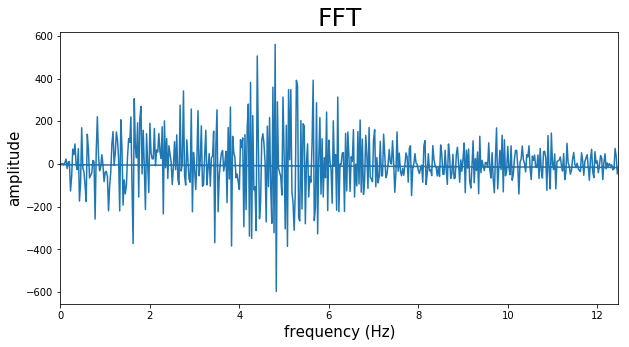

In [21]:
ss = np.sqrt(np.power(df['implant','x'].values,2)+np.power(df['implant','y'].values,2))[:1000]
fig = plt.figure(figsize=(15,10))
# s = ss - moving_average_array(ss,4)
filtered = gaussian_filter1d(ss,4)
s = ss - filtered

plt.plot(ss)
plt.plot(filtered)
plt.title('Implant tracking in time',fontsize = 25)


freq_range = [3,6]
fps = 25
dt = 1/fps
f_signal = fft(s)
W = fftfreq(s.size, d=dt)
print(s.size,f_signal.shape, W.shape)
#%matplotlib auto


cut_f_signal = f_signal.copy()
cut_f_signal[(np.abs(W)<freq_range[0]) | (np.abs(W)>freq_range[1])] = 0 # cut signal above 3Hz
cs = ifft(cut_f_signal)

W_trem = fftfreq(s[200:600].size, d=dt) # verified tremor interval
f_signal_trem = rfft(s[200:600])

print('tremor freq =',W_trem[np.argmax(abs(f_signal_trem))])
fig = plt.figure(figsize=(15,10))
plt.plot(s, label = 'signal - moving average')
plt.plot(cs, label = 'frequency filtered signal')
plt.title('Filter with FFT',fontsize = 25)
plt.legend(fontsize = 15)

fig = plt.figure(figsize=(15,10))
y = butter_bandpass_filter(s, freq_range[0],freq_range[1], fps, order=4)
plt.title('Filter signal.filt', fontsize = 25)
plt.plot(s,label = 'signal - moving average')
plt.plot(y,label = 'frequency filtered signal')
plt.legend(fontsize = 15)


fig = plt.figure(figsize=(10,5))
plt.plot(W, f_signal)
# plt.ylim([10,np.max(f_signal)]) 
plt.xlim([0,np.max(W)])
plt.title('FFT', fontsize = 25)
plt.xlabel('frequency (Hz)', fontsize = 15)
plt.ylabel('amplitude', fontsize = 15)

# Highlight tremors

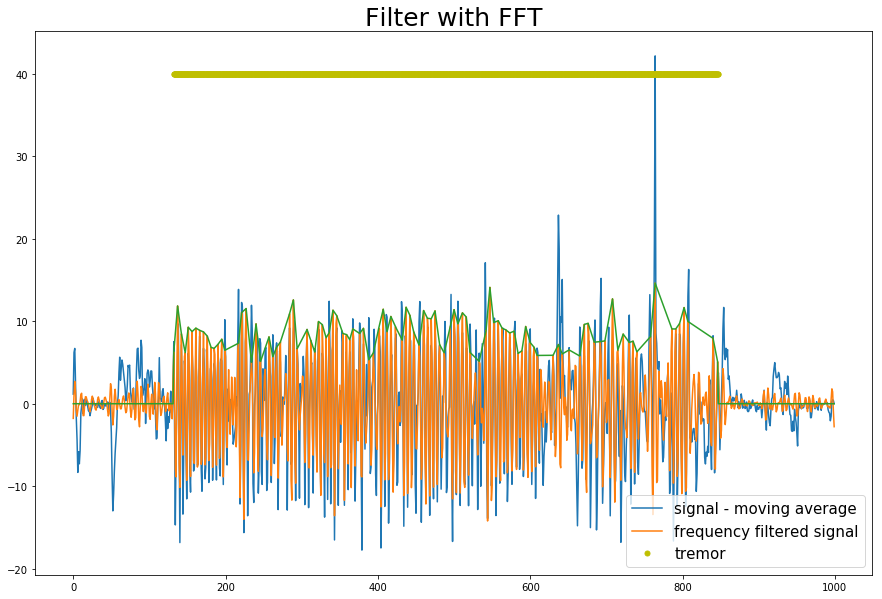

In [14]:
threshold = 5
peaks,_ = signal.find_peaks(cs, height = threshold)
sig = np.zeros_like(cs)
sig[peaks] = cs[peaks]

for i in range(len(peaks)-1):
    if peaks[i+1] == peaks[i]+1:
        continue    
    x = np.arange(peaks[i]+1,peaks[i+1])
    in_between = sig[peaks[i]] + (sig[peaks[i+1]]-sig[peaks[i]])/(peaks[i+1]-peaks[i])*(x-peaks[i])
    sig[peaks[i]+1:peaks[i+1]] = in_between

fig =plt.figure(figsize=(15,10))
plt.plot(s, label = 'signal - moving average')
plt.plot(cs, label = 'frequency filtered signal')
plt.title('Filter with FFT',fontsize = 25)

plt.plot(sig)
trem_ind  = np.where(sig>threshold)
plt.plot(trem_ind,np.ones_like(trem_ind)*40, 'o', markersize = 5, c = 'y')
plt.plot(trem_ind[-1],np.ones_like(trem_ind[-1])*40, 'o', markersize = 5, c = 'y', label = 'tremor')
plt.legend(fontsize = 15)

# DLC Demo

0
20
40
60
80
100
120
140
160
180
200
220
240
260
280
300
320
340
360
380
400
420
440
460
480
500
520
540
560
580
600
620
640
660
680
700
720
740
760
780
800
820
840
860
880
900
920
940
960
980


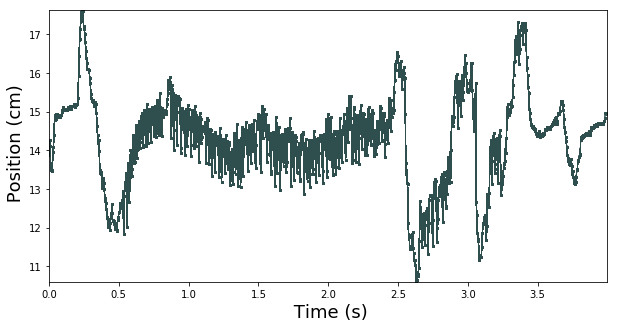

In [11]:
path = '/home/shiva/Desktop/Dyskinesia'
scale_pix_to_cm = 8/130
file_name = '#182_L-DOPA_opto_day15_0.5mWDLC_resnet50_Dyskinesia_Ldopa_MouseFeb5shuffle1_250000.csv'
df = pd.read_csv(os.path.join(path,file_name), header=[1,2])
x = np.sqrt(np.power(df['implant','x'].values,2)+np.power(df['implant','y'].values,2))*scale_pix_to_cm
start = 0 ;  stop = 1000
x = x[start:stop]
time_series = np.arange(start,stop)/250
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(10, 5), sharey=True)
ax.get_xaxis().set_tick_params(direction='out',labelsize = 10)
ax.xaxis.set_ticks_position('bottom')
ax.get_yaxis().set_tick_params(direction='out',labelsize = 10)
ax.yaxis.set_ticks_position('left')
plt.xlim(min(time_series),max(time_series))
plt.ylim(min(x),max(x))

for i in range(0,stop-start):
    if i%20 == 0:
        print(i)
    plt.plot(time_series[:i], x[:i], '-o', markersize = 2, lw = 0.8,c = 'darkslategrey')
    plt.ylabel(" Position (cm)",fontsize = 18)
    plt.xlabel(" Time (s)",fontsize = 18)
    plt.savefig('/home/shiva/Desktop/Dyskinesia/tracking/frame'+str(i).zfill(5)+'.png',bbox_inches='tight',orientation='landscape',dpi=300)